<a href="https://colab.research.google.com/github/orin00/bucheon_Green/blob/main/test_model_simpleCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# 현재 위치 확인
!pwd

/content


In [13]:
# 현재 위치 이동
%cd /content/drive/MyDrive/0_team_1

/content/drive/MyDrive/0_team_1


In [14]:
%cd  /content/drive/MyDrive/0_team_1/baby_datasets

/content/drive/MyDrive/0_team_1/baby_datasets


In [15]:
# zip 파일 압축해제
# !unzip '/content/drive/MyDrive/0_team_1/baby_datasets/baby_datasets.zip'

In [33]:
from glob import glob

train_img = glob('/content/drive/MyDrive/0_team_1/baby_datasets/train/images/*.jpg')
test_img = glob('/content/drive/MyDrive/0_team_1/baby_datasets/test/images/*.jpg')
valid_img = glob('/content/drive/MyDrive/0_team_1/baby_datasets/valid/images/*.jpg')
print(len(train_img), len(test_img), len(valid_img))

1377 197 393


In [34]:
# yaml 파일 생성
import yaml

%cat /content/drive/MyDrive/0_team_1/baby_datasets/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['BF']

roboflow:
  workspace: zoo10th
  project: mother-s-grow
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/zoo10th/mother-s-grow/dataset/2

In [13]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [15]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 70.1 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.2.0 which is incompatible.


In [35]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization
from glob import glob
import yaml
from PIL import Image

In [36]:
with open('/content/drive/MyDrive/0_team_1/baby_datasets/data.yaml', 'r') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)

train_img = data['train']
valid_img = data['val']
test_img = data['test']

In [37]:
# 이미지 변환
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    fixed_image_standardization
])

In [38]:
# 데이터셋 생성
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img

In [39]:
train_dataset = CustomDataset(train_img, transform=transform)
valid_dataset = CustomDataset(valid_img, transform=transform)
test_dataset = CustomDataset(test_img, transform=transform)

In [40]:
# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [41]:
# MTCNN 불러오기
mtcnn = MTCNN(keep_all=True)

In [42]:
# 전이 학습할 모델 정의
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [43]:
# 학습 파라미터 설정
epochs = 5
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [57]:
%pwd

'/content/drive/MyDrive/0_team_1/baby_datasets'

In [48]:
from glob import glob

train_img = glob('/content/drive/MyDrive/0_team_1/baby_datasets/train/images/*.jpg')
test_img = glob('/content/drive/MyDrive/0_team_1/baby_datasets/test/images/*.jpg')
valid_img = glob('/content/drive/MyDrive/0_team_1/baby_datasets/valid/images/*.jpg')

print(len(train_img), len(test_img), len(valid_img))

# 데이터 로드
with open('/content/drive/MyDrive/0_team_1/baby_datasets/data.yaml', 'r') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)

train_img = data['train']
valid_img = data['val']
test_img = data['test']

print(train_img)  # 처음 다섯 개의 파일 경로 출력
print(valid_img)  # 처음 다섯 개의 파일 경로 출력
print(test_img)   # 처음 다섯 개의 파일 경로 출력

1377 197 393
../train/images
../valid/images
../test/images


In [66]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from PIL import Image

# GPU를 사용할 수 있는 경우 GPU를 사용하고, 그렇지 않은 경우 CPU를 사용합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터셋 경로
train_path = '/content/drive/MyDrive/0_team_1/baby_datasets/train/images/'
test_path = '/content/drive/MyDrive/0_team_1/baby_datasets/test/images/'

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

train_dataset = CustomDataset(root_dir=train_path, transform=transform)
test_dataset = CustomDataset(root_dir=test_path, transform=transform)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

# DataLoader를 사용하여 데이터를 불러옵니다.
batch_size = 32  # 배치 크기를 지정합니다. 이 부분은 필요에 따라 수정할 수 있습니다.
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 간단한 CNN 모델을 정의합니다.
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델을 생성하고 GPU 또는 CPU로 이동합니다.
model = SimpleCNN().to(device)

# 손실 함수와 옵티마이저를 정의합니다.
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 하이퍼파라미터를 설정합니다.
epochs = 10

# 학습을 수행합니다.
for epoch in range(epochs):
    model.train()
    for imgs in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, torch.ones(outputs.shape[0], 1).to(device))
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for imgs in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            predictions = torch.sigmoid(outputs) > 0.5
            total += imgs.size(0)
            correct += (predictions == 1).sum().item()
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Test Accuracy: {accuracy:.2f}%')

# 모델의 상태를 저장합니다.
torch.save(model.state_dict(), '/content/drive/MyDrive/0_team_1/baby_datasets/simple_cnn.pth')

Number of training images: 1377
Number of test images: 197
Epoch [1/10], Test Accuracy: 400.00%
Epoch [2/10], Test Accuracy: 400.00%
Epoch [3/10], Test Accuracy: 400.00%
Epoch [4/10], Test Accuracy: 400.00%
Epoch [5/10], Test Accuracy: 400.00%
Epoch [6/10], Test Accuracy: 400.00%
Epoch [7/10], Test Accuracy: 400.00%
Epoch [8/10], Test Accuracy: 400.00%
Epoch [9/10], Test Accuracy: 400.00%
Epoch [10/10], Test Accuracy: 400.00%


torch.Size([5, 3, 224, 224])


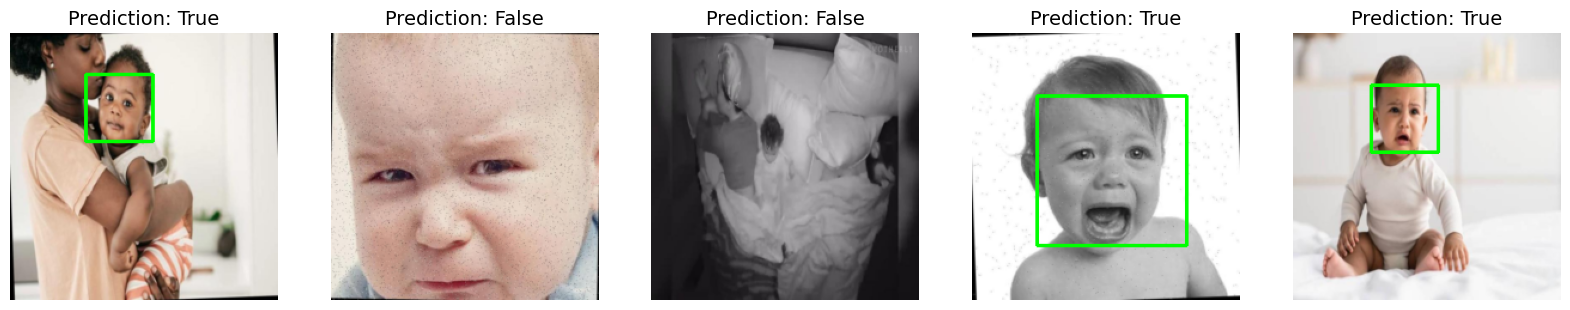

In [96]:
import random

# 얼굴을 감지하고 사각형을 그리는 함수
def draw_face_rectangles(image, faces):
    image_with_rect = image.copy()
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            cv2.rectangle(image_with_rect, (x, y), (x+w, y+h), (0, 255, 0), 2)
        return image_with_rect, True
    else:
        return image_with_rect, False

# 시각화할 이미지의 수
num_images = 5

# 시각화할 이미지를 무작위로 가져옵니다.
dataiter = iter(test_loader)
images = next(dataiter)
images = images.to(device)
indices = random.sample(range(images.size(0)), num_images)
images = images[indices]

# 이미지의 차원 개수 확인
print(images.shape)

# 이미지를 모델에 통과시킵니다.
model.eval()
with torch.no_grad():
    outputs = model(images)
    predictions = torch.sigmoid(outputs)  # 확률값으로 변환

# 확률값을 0 또는 1로 변환합니다.
predictions = (predictions > 0.5).int()

# 얼굴 감지기를 정의합니다.
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 이미지와 예측을 시각화합니다.
fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
for idx in range(num_images):
    ax = axes[idx]
    image = images[idx].cpu().numpy()
    image = np.clip(image, 0, 1)

    # 이미지에서 얼굴을 감지합니다.
    image_uint8 = (image.transpose((1, 2, 0)) * 255).astype(np.uint8)
    gray = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # 얼굴 주위에 사각형을 그리고 예측값을 출력합니다.
    image_with_rect, face_detected = draw_face_rectangles(image_uint8, faces)  # 이미지를 복사하여 전달

    ax.imshow(image_with_rect)
    ax.axis('off')
    ax.set_title('Prediction: {}'.format(bool(predictions[idx].item() and face_detected)), fontsize=14)
plt.show()


In [71]:
print(images.shape)

torch.Size([3, 224, 224])


In [63]:
import os

# train 폴더 안의 하위 디렉토리를 확인합니다.
train_folder_contents = os.listdir(train_path)
print(train_folder_contents)

['732.jpg', '26.jpg', '505.jpg', '355.jpg', '474.jpg', '817.jpg', '517.jpg', '16.jpg', '654.jpg', '75.jpg', '1376.jpg', '47.jpg', '165.jpg', '327.jpg', '592.jpg', '538.jpg', '268.jpg', '1247.jpg', '791.jpg', '1025.jpg', '220.jpg', '816.jpg', '1172.jpg', '608.jpg', '438.jpg', '1235.jpg', '783.jpg', '1012.jpg', '820.jpg', '717.jpg', '442.jpg', '770.jpg', '1147.jpg', '393.jpg', '252.jpg', '1081.jpg', '665.jpg', '1102.jpg', '1341.jpg', '583.jpg', '1365.jpg', '444.jpg', '107.jpg', '248.jpg', '1193.jpg', '1198.jpg', '741.jpg', '198.jpg', '560.jpg', '362.jpg', '407.jpg', '542.jpg', '173.jpg', '772.jpg', '114.jpg', '366.jpg', '1136.jpg', '680.jpg', '649.jpg', '917.jpg', '859.jpg', '1013.jpg', '1199.jpg', '398.jpg', '767.jpg', '1127.jpg', '1274.jpg', '1112.jpg', '1163.jpg', '1039.jpg', '491.jpg', '317.jpg', '1311.jpg', '1062.jpg', '547.jpg', '430.jpg', '556.jpg', '959.jpg', '456.jpg', '19.jpg', '1088.jpg', '972.jpg', '1343.jpg', '1291.jpg', '575.jpg', '998.jpg', '207.jpg', '33.jpg', '1320.jpg',

In [64]:
# test 폴더 안의 하위 디렉토리를 확인합니다.
test_folder_contents = os.listdir(test_path)
print(test_folder_contents)

['191.jpg', '170.jpg', '52.jpg', '151.jpg', '130.jpg', '77.jpg', '119.jpg', '34.jpg', '144.jpg', '93.jpg', '55.jpg', '36.jpg', '9.jpg', '6.jpg', '167.jpg', '35.jpg', '70.jpg', '81.jpg', '16.jpg', '146.jpg', '46.jpg', '80.jpg', '58.jpg', '135.jpg', '32.jpg', '67.jpg', '69.jpg', '163.jpg', '24.jpg', '180.jpg', '3.jpg', '147.jpg', '145.jpg', '30.jpg', '184.jpg', '192.jpg', '150.jpg', '117.jpg', '97.jpg', '104.jpg', '15.jpg', '171.jpg', '89.jpg', '19.jpg', '50.jpg', '106.jpg', '190.jpg', '183.jpg', '96.jpg', '12.jpg', '131.jpg', '94.jpg', '149.jpg', '181.jpg', '107.jpg', '152.jpg', '185.jpg', '72.jpg', '123.jpg', '122.jpg', '92.jpg', '90.jpg', '140.jpg', '59.jpg', '51.jpg', '39.jpg', '172.jpg', '124.jpg', '14.jpg', '120.jpg', '33.jpg', '161.jpg', '177.jpg', '86.jpg', '162.jpg', '168.jpg', '28.jpg', '42.jpg', '154.jpg', '73.jpg', '127.jpg', '166.jpg', '21.jpg', '132.jpg', '7.jpg', '23.jpg', '129.jpg', '102.jpg', '78.jpg', '60.jpg', '62.jpg', '100.jpg', '83.jpg', '156.jpg', '143.jpg', '195.j

In [49]:
# 학습
for epoch in range(epochs):
    resnet.train()
    for imgs in train_loader:
        imgs = mtcnn(imgs.to(device))
        embeddings = resnet(imgs.to(device))
        optimizer.zero_grad()
        loss = criterion(embeddings, labels.to(device))
        loss.backward()
        optimizer.step()

    resnet.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for imgs, labels in test_loader:
            imgs = mtcnn(imgs.to(device))
            embeddings = resnet(imgs.to(device))
            _, predicted = torch.max(embeddings.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Test Accuracy: {accuracy:.2f}%')

FileNotFoundError: [Errno 2] No such file or directory: 'e'

In [10]:
# !git clone https://github.com/ultralytics/yolov5

In [9]:
# %cd yolov5
# !pip install -r requirements.txt

In [8]:
# data.yaml에 nc를 읽어오기
#import yaml

#with open('/content/drive/MyDrive/0_team_1/baby_datasets/data.yaml', 'r') as stream:
#  num_classes = str(yaml.safe_load(stream)['nc'])

#%cat /content/drive/MyDrive/0_team_1/baby_datasets/yolov5/models/yolov5s.yaml

In [7]:
#%cd /content/drive/MyDrive/0_team_1/baby_datasets/yolov5

#!python train.py --img 640 --batch 32 --epochs 100 --data /content/drive/MyDrive/0_team_1/baby_datasets/data.yaml --cfg /content/drive/MyDrive/0_team_1/baby_datasets/yolov5/models/yolov5s.yaml --weights yolov5s.pt --name food_result --cache

In [6]:
#%cd /content/drive/MyDrive/0_team_1/baby_datasets/yolov5

In [5]:
#%load_ext tensorboard
#%tensorboard --logdir runs

In [4]:
#from IPython.display import Image
#Image(filename='/content/drive/MyDrive/0_team_1/baby_datasets/yolov5/runs/train/food_result/results.png')

In [3]:
#!python detect.py --weights /content/drive/MyDrive/0_team_1/baby_datasets/yolov5/runs/train/food_result/weights/best.pt --img 640 --conf 0.1 --source /content/drive/MyDrive/0_team_1/baby_datasets/test/images

In [2]:
#import glob
#import random
#from IPython.display import Image, display

#image_name = random.choice(glob.glob('/content/drive/MyDrive/0_team_1/baby_datasets/yolov5/runs/detect/exp/*.jpg'))
#display(Image(filename=image_name))

In [ ]:
# !git clone https://github.com/ultralytics/yolov5.git
# %cd yolov5
# !pip install -r requirements.txt
# !pip install

In [ ]:
!pip install opencv-python